### Justification for the look-alike innovation

#### Both 3D cinemas and the Hologram Zoo are technological advancements that aim to enhance the visual experience of viewers by adding depth or lifelike experiences to what is traditionally a two-dimensional viewing space. They both represent leaps in how we consume visual media, transitioning from passive viewing to interactive experiences.

### Justification for the data


#### The data is taken from https://www.statista.com/statistics/440221/digital-3d-screens-in-european-countries/. The annual data of sales from 2009 to 2018 for 3D cinemas can serve as a good proxy for the initial adoption and growth phase of a similar entertainment technology.

### Imports

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

In [34]:
df = pd.read_excel('cinema_data.xlsx')

print(df)

   Year  Count
0  2009   2961
1  2010   6968
2  2011  10073
3  2012  11639
4  2013  13136
5  2014  13158
6  2015  13985
7  2016  14278
8  2017  15499
9  2018  14543


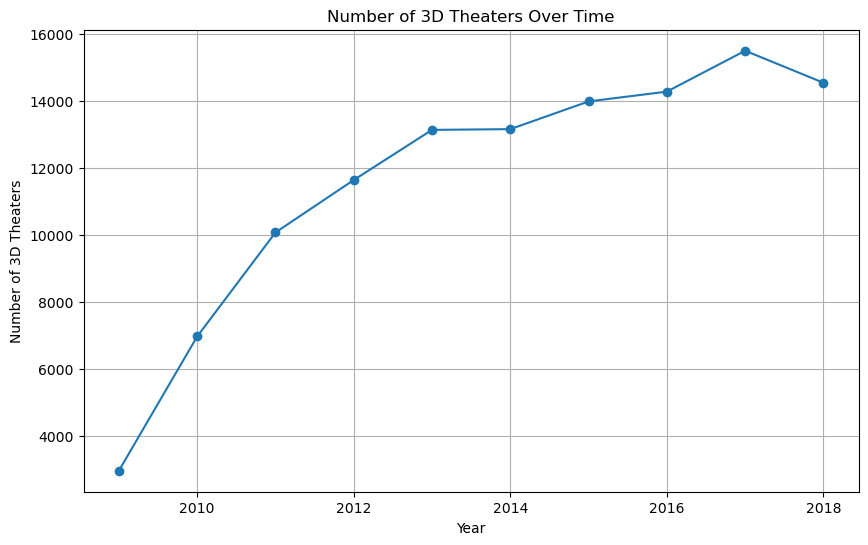

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(df['Year'], df['Count'], marker='o')
plt.title('Number of 3D Theaters Over Time')
plt.xlabel('Year')
plt.ylabel('Number of 3D Theaters')
plt.grid(True)
plt.show()

In [36]:
def bass_model(t, p, q, m):
    """
    Bass model function
    p: Coefficient of innovation
    q: Coefficient of imitation
    m: Potential market size
    t: Time period
    """
    adoption = m * (((p + q)**2 / p) * np.exp(-(p + q) * t) / ((1 + (q / p) * np.exp(-(p + q) * t))**2))
    return adoption


In [37]:
# Subtract the smallest year from all years to create a time series starting at 0
t = np.array(df['Year'] - df['Year'].min())

# Convert the 'Count' column to an array for use in modeling
N = np.array(df['Count'])

In [38]:
# Set initial guesses for the Bass model parameters
guess = [0.03, 0.38, max(N)]  # p (innovation), q (imitation), m (market size)

# Fit the Bass model to the data using curve_fit, with the initial parameter guess
params, covariance = curve_fit(bass_model, t, N, p0=guess, maxfev=10000)

# Extract the fitted parameters p, q, and m from the output
p, q, m = params

In [16]:
print(f'Estimated Coefficient of Innovation (p): {p}')
print(f'Estimated Coefficient of Imitation (q): {q}')
print(f'Estimated Potential Market Size (m): {m}')


Estimated Coefficient of Innovation (p): 0.03103119042294525
Estimated Coefficient of Imitation (q): 0.2782770103485192
Estimated Potential Market Size (m): 177636.67683359515


In [40]:
def predict_adopters(bass_params, years_to_predict, start_year):
    # Unpack the Bass model parameters: p (innovation), q (imitation), m (market size)
    p, q, m = bass_params
    
    # Initialize the list to store predicted adoptions starting with 0 (no adopters at start)
    adoption = [0]  
    
    # Calculate cumulative adoption for each year in the prediction period
    for t in range(1, years_to_predict + 1):
        adoption.append(bass_model(t, p, q, m))
    
    # The initial number of adopters before the prediction starts
    initial_adopters = adoption[-1]
    
    # Calculate the predicted adoption for each year and subtract initial adopters to get annual adoption
    predicted_adoption = [initial_adopters + bass_model(t, p, q, m) for t in range(1, years_to_predict + 1)]
    
    # Return the annual predicted adoption
    return np.array(predicted_adoption) - initial_adopters

In [41]:
# Set the number of years to predict into the future
years_to_predict = 10

# Determine the start year for predictions by taking the maximum year in the dataset and adding 1
start_year = df['Year'].max() + 1

# Call the predict_adopters function with the Bass model parameters and the number of years to predict
# This function returns the predicted number of adopters for each year in the future
predicted_adopters = predict_adopters((p, q, m), years_to_predict, start_year)

In [20]:
df_predictions = pd.DataFrame({
    'Year': np.arange(start_year, start_year + years_to_predict),
    'Predicted_Adopters': predicted_adopters.cumsum()
})

print(df_predictions)

   Year  Predicted_Adopters
0  2019         6992.552495
1  2020        15670.203233
2  2021        26149.867743
3  2022        38397.062051
4  2023        52171.956824
5  2024        67012.481508
6  2025        82277.249521
7  2026        97247.972632
8  2027       111259.996381
9  2028       123813.067173


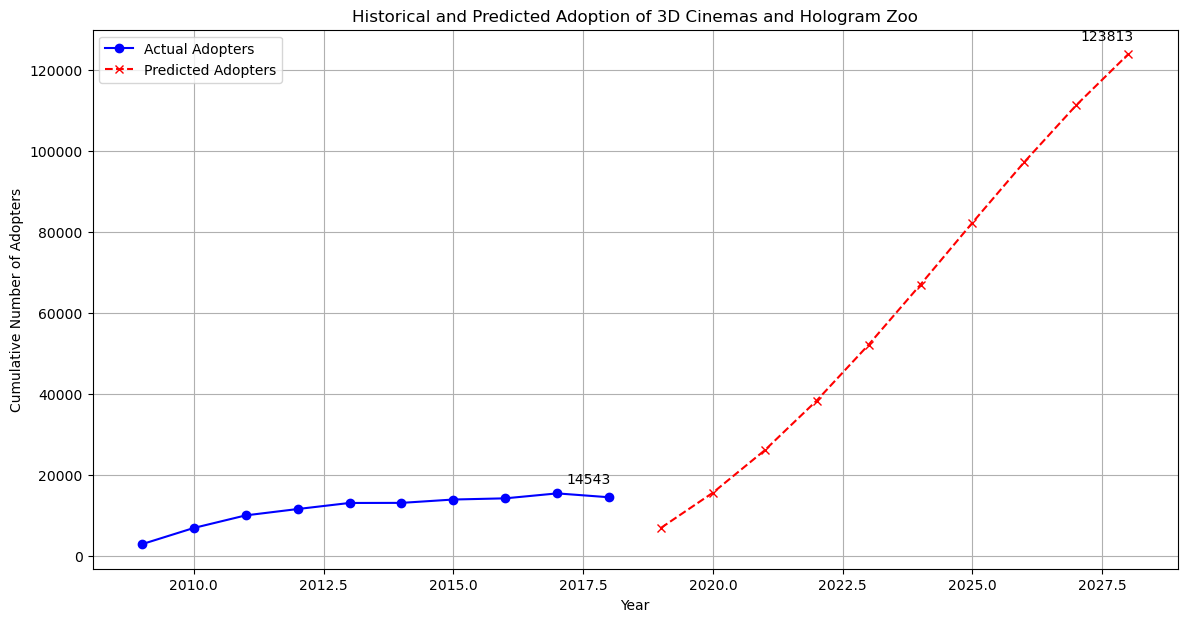

In [33]:
df_combined = pd.concat([
    df.rename(columns={'Adopters': 'Adopters_Cumulative'}).assign(Type='Actual'),
    df_predictions.rename(columns={'Predicted_Adopters': 'Adopters_Cumulative'}).assign(Type='Predicted')
])

# Plot the actual and predicted adopters
plt.figure(figsize=(14, 7))

# Plot actual data
plt.plot(df['Year'], df['Count'], label='Actual Adopters', color='blue', marker='o')

# Plot predicted data
plt.plot(df_predictions['Year'], df_predictions['Predicted_Adopters'], label='Predicted Adopters', color='red', linestyle='--', marker='x')

# Annotations for the last actual and predicted points
plt.annotate(f"{df['Count'].iloc[-1]}",
             (df['Year'].iloc[-1], df['Count'].iloc[-1]),
             textcoords="offset points", xytext=(-15,10), ha='center')
plt.annotate(f"{int(df_predictions['Predicted_Adopters'].iloc[-1])}",
             (df_predictions['Year'].iloc[-1], df_predictions['Predicted_Adopters'].iloc[-1]),
             textcoords="offset points", xytext=(-15,10), ha='center')

# Plot details
plt.title('Historical and Predicted Adoption of 3D Cinemas and Hologram Zoo')
plt.xlabel('Year')
plt.ylabel('Cumulative Number of Adopters')
plt.legend()
plt.grid(True)
plt.show()